## Perform standard imports

In [ ]:
! pip install split-folders

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Early Stopping Criterion for NN

/content/drive/MyDrive/12. Convolutional Neural Network (CNN)


## Prepare train and test sets, loaders

In [ ]:
splitfolders.ratio("Circle_Cross", output="Train_Test",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 2001 files [00:01, 1106.10 files/s]


# Creating train and test data generators

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
num_classes = 2
img_shape = (116,116,3)
batch_size = 32

## Creating Training and Testing Datasets


In [ ]:
training_set = train_datagen.flow_from_directory('Train_Test/train',
                                                 target_size = (116,116),
                                                 class_mode='binary',
                                                 shuffle = True,
                                                 batch_size = batch_size)


Found 1599 images belonging to 2 classes.


In [ ]:
test_set = train_datagen.flow_from_directory('Train_Test/val',
                                                 target_size = (116,116),
                                                 class_mode='binary',
                                                 shuffle = False,
                                                 batch_size = batch_size)


Found 401 images belonging to 2 classes.


##  Create CNN

In [ ]:
model = Sequential()
model.add(Conv2D(10 ,kernel_size = (5, 5), padding = 'SAME', input_shape = img_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model.add(Conv2D(20, (5, 5), padding='SAME')) # "SAME" tries to pad evenly left and right
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 116, 116, 10)      760       
                                                                 
 activation_4 (Activation)   (None, 116, 116, 10)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 58, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 20)        5020      
                                                                 
 activation_5 (Activation)   (None, 58, 58, 20)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 20)       0         
 2D)                                                  

# Setting Early Stopping Criterion

In [ ]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                             min_delta = 0,
                             patience = 3,
                             verbose =1,
                             restore_best_weights = True)


# Training and Testing the model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9) ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(training_set,
                              epochs = 500,
                              validation_data = test_set,
                              callbacks = earlystop)

Epoch 1/500
50/50 [==============================] - 14s 269ms/step - loss: 0.4450 - accuracy: 0.7630 - val_loss: 0.1041 - val_accuracy: 0.9651
Epoch 2/500
50/50 [==============================] - 8s 154ms/step - loss: 0.0541 - accuracy: 0.9819 - val_loss: 0.0319 - val_accuracy: 0.9925
Epoch 3/500
50/50 [==============================] - 8s 153ms/step - loss: 0.0197 - accuracy: 0.9962 - val_loss: 0.0232 - val_accuracy: 0.9975
Epoch 4/500
50/50 [==============================] - 8s 159ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0187 - val_accuracy: 0.9950
Epoch 5/500
50/50 [==============================] - 9s 170ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0175 - val_accuracy: 0.9975
Epoch 6/500
50/50 [==============================] - 9s 186ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9975
Epoch 7/500
50/50 [==============================] - 7s 145ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.995

In [ ]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

# Visualize the Model Performance

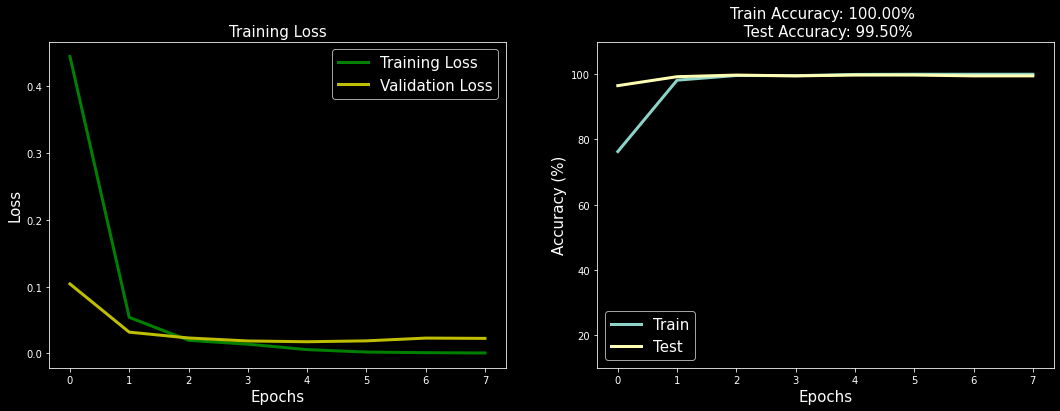

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Training Loss')
ax[0].plot(hist.history['val_loss'], 'y', lw = 3, label = 'Validation Loss')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)


ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()